Creating a PDF using NOMAD data
-----------------------------------

In [1]:
# setup plotting
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
plt.xkcd() # comment this out for serious science
# useful modules
import os
# ...and, of course, mantid
from mantid.simpleapi import *

Summary of interesting runs in the proposal
-------------------------------------------------

| run | duration | size | title |
|---|---|---|---|
| NOM_79329 | 5626.6s | 13GB | diamond |
| NOM_79330 | 3284.2s | 13GB | diamond |
| NOM_79331 | 2098.9s | 3.6GB | empty_V_6mm
| NOM_79332 | 1961.1s | 4.4GB | Si_standard_6mm
| NOM_79333 | 1929.2s | 3.6GB | empty_Vcan_NOMAD_6mm
| NOM_79334 | 1932.6s | 2.9GB | empty_instrument
| NOM_79335 | 1928.6s | 9.1GB | V_rod_6mm
| NOM_79336 | 1931.6s | 3.6GB | empty_vcan_6mm_NIST
| NOM_79337 | 1948.9s | 3.6GB | empty_vcan_6mm_NIST
| NOM_79338 | 3269.83 | 3.6GB | empty_vcan_6mm_NIST
| NOM_79339 | 1920.7s | 3.6GB | empty_vcan_6mm_NIST
| NOM_79340 | 1922.2s | 3.6GB | empty_vcan_6mm_NIST
| NOM_79341 | 1983.8s | 3.6GB | empty_vcan_6mm_NIST
| NOM_79342 |  894.9s | 1.7GB | empty_vcan_6mm_NIST

In [2]:
# only 'hints' are required because filenames are searched for
filenames = ['NOM_79330', # diamond
             'NOM_79331', # diamond background
             'NOM_79335', # vanadium
             'NOM_79334', # vanadium background
            ]
filenames = ['NOM_79584', # diamond
             'NOM_79583', # diamond background
             'NOM_79335', # vanadium
             'NOM_79334', # vanadium background
            ]
calibrationFile='/SNS/NOM/shared/CALIBRATION/2016_2_1B_CAL/NOM_d79330_2016_09_07.h5'
#characterizationFile='/SNS/NOM/shared/CALIBRATION/2016_2_1B_CAL/NOM_char_2016_08_18-pdf.txt'

In [10]:
def LoadAndConvert(name):
    LoadEventAndCompress(Filename=name,
                         OutputWorkspace=name,
                         MaxChunkSize=8, # in GB
                         FilterBadPulses=10)
    AlignAndFocusPowder(InputWorkspace=name,
                        OutputWorkspace=name,
                        CalFilename=calibrationFile,
                        ResampleX=-6000,
                        DMin=(.31,.25,.13,.13,.13,.42),
                        DMax=(13.66,5.83,3.93,2.09,1.57,31.42),
                        TMin=300,
                        TMax=16667,
                        CropWavelengthMin=.1,
                        CropWavelengthMax=2.9,
                        PreserveEvents=False, # binning will have a smoothing effect after this
                        RemovePromptPulseWidth=50)
    ConvertToPointData(InputWorkspace=name, OutputWorkspace=name)
    ConvertUnits(InputWorkspace=name, OutputWorkspace=name,
                 EMode='Elastic', Target='MomentumTransfer')

In [3]:
# get partially reduced files 
for name in filenames:
    # to speed things up - convert to PDFgetN files with 6 banks
    if os.path.exists(os.path.join(os.curdir, name+'.getn')):
        print 'cache file already exists',
    else:
        print 'need to create cache file for', name
        PDToPDFgetN(Filename=name, MaxChunkSize=8, # in GB
                    RemovePromptPulseWidth=50.,
                    FilterBadPulses=0.,
                    ResampleX=-6000,
                    CalibrationFile=calibrationFile, # calibrated TOF->d
                    CharacterizationRunsFile=characterizationFile, # ranges for tof and d-spacing
                    CropWavelengthMin=.1,  # for 60Hz - will be in characterizations soon
                    CropWavelengthMax=2.9, # for 60Hz - will be in characterizations soon
                    OutputWorkspace=name,
                    PDFgetNFile=os.path.join(os.curdir, name+'.getn')
                   )
    # the `.getn` files are histograms so re-loading them will cut down on memory
    print 'loading', name+'.getn'
    #LoadGSS(Filename=os.path.join(os.curdir, name+'.getn'), OutputWorkspace=name)
    ConvertToPointData(InputWorkspace=name, OutputWorkspace=name)
    ConvertUnits(InputWorkspace=name, OutputWorkspace=name,
            EMode='Elastic', Target='MomentumTransfer')

need to create cache file for NOM_79584
loading NOM_79584.getn
need to create cache file for NOM_79583
loading NOM_79583.getn
need to create cache file for NOM_79335
loading NOM_79335.getn
need to create cache file for NOM_79334
loading NOM_79334.getn


In [11]:
for name in filenames:
    LoadAndConvert(name)

In [12]:
for name in filenames:
    print name,mtd[name].run().getProtonCharge()

NOM_79584 6008.434835
NOM_79583 3557.9791776
NOM_79335 3882.77176457
NOM_79334 1109.52078222


In [ ]:
# do the "simple" background correction for signal and vanadium, also set the chemical formula
# this could be fancier and set the sample number density using information about the space
# or define the sample geometry using `SetSample`
diamond_banks = mtd['NOM_79330']
#diamond_banks -= mtd['NOM_79331']
#DeleteWorkspace('NOM_79331')
SetSampleMaterial(InputWorkspace=diamond_banks, ChemicalFormula='C')

vanadium_banks = mtd['NOM_79335']
#vanadium_banks -= mtd['NOM_79334']
#DeleteWorkspace('NOM_79334')
SetSampleMaterial(InputWorkspace=vanadium_banks, ChemicalFormula='V')

<IPython.core.display.Javascript object>


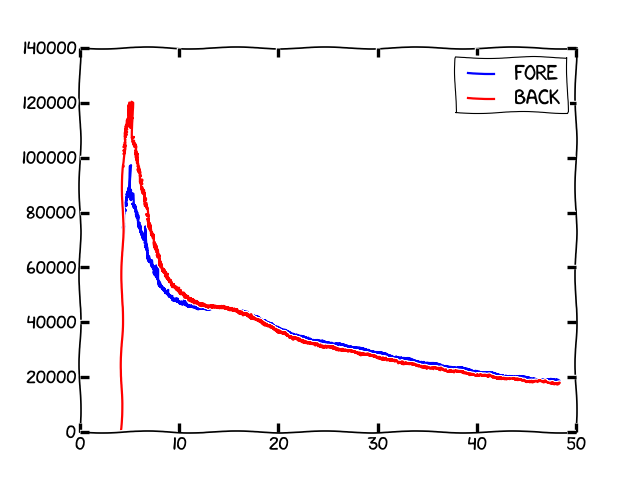

In [14]:
fig, axes  = plt.subplots()
for i in [4]: #xrange(6):
    axes.plot(mtd['NOM_79335'].readX(i), mtd['NOM_79335'].readY(i), label='fore')
    axes.plot(mtd['NOM_79334'].readX(i), mtd['NOM_79334'].readY(i)/1109*3382, label='back')
axes.legend()

In [ ]:
a=vanadium_banks.run()
a.getProtonCharge()